# Initial Setup

In [243]:
# --- Environment Setup ---
# Run this cell if you are using Google Colab or a fresh environment without dependencies installed.
# If you are running locally with the Conda environment set up (per README), you can skip this.

try:
    import qiskit
    import qiskit_finance
    print("✅ Libraries are already installed.")
except ImportError:
    print("⏳ Libraries not found. Installing now... (This may take a few minutes)")
    %pip install qiskit qiskit-finance qiskit-algorithms qiskit-aer qiskit-ibm-runtime quantuminspire matplotlib pylatexenc python-dotenv
    print("✅ Installation complete. Please restart the runtime/kernel if needed.")

✅ Libraries are already installed.


In [244]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import StatevectorSampler, BackendSamplerV2
from qiskit.circuit.library import LinearAmplitudeFunctionGate, UCRYGate, GroverOperator, RYGate
from qiskit.quantum_info import Statevector

from qiskit_finance.circuit.library import LogNormalDistribution
from qiskit_finance.applications.estimation import EuropeanCallPricing, EuropeanCallDelta

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2

from dotenv import load_dotenv
load_dotenv()

import os
import json
from pathlib import Path

In [245]:
spot_price = 2.0
strike_price = 1.896
volatility = 0.4
risk_free_rate = 0.05
time_to_maturity = 40 / 365

DEFAULT_SHOTS = 4096

In [246]:
# ===== Persistent results logging (PRICE only) =====
# - Logs to memory (PRICE_LOG) and appends to results/summary_prices.csv + .jsonl
# - Analysis can load from files if variables are absent (no reruns needed)
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

CSV_PATH = RESULTS_DIR / "summary_prices.csv"
JSONL_PATH = RESULTS_DIR / "summary_prices.jsonl"

PRICE_LOG = []  # in-memory rows (optional)

def record_result(method: str, estimate: float, ci_low=None, ci_high=None, **meta):
    """
    Append one price result to memory and to disk.
    """
    row = {
        "Method": method,
        "Estimate": float(estimate),
        "CI Low": float(ci_low) if ci_low is not None else np.nan,
        "CI High": float(ci_high) if ci_high is not None else np.nan,
    }
    row.update(meta)

    # normalize CI bounds if swapped
    if np.isfinite(row["CI Low"]) and np.isfinite(row["CI High"]) and row["CI Low"] > row["CI High"]:
        row["CI Low"], row["CI High"] = row["CI High"], row["CI Low"]

    PRICE_LOG.append(row)

    # append JSONL (one JSON object per line)
    with open(JSONL_PATH, "a", encoding="utf-8") as f:
        f.write(json.dumps(row) + "\n")

    # append to CSV (create header if needed)
    df_new = pd.DataFrame([row])
    if CSV_PATH.exists():
        df_new.to_csv(CSV_PATH, mode="a", header=False, index=False)
    else:
        df_new.to_csv(CSV_PATH, mode="w", header=True, index=False)

def load_results_from_files():
    """
    Load results from disk:
      - prefer CSV if present
      - fall back to JSONL
    Returns a DataFrame (may be empty).
    """
    if CSV_PATH.exists():
        return pd.read_csv(CSV_PATH)
    if JSONL_PATH.exists():
        rows = []
        with open(JSONL_PATH, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if line:
                    rows.append(json.loads(line))
        return pd.DataFrame(rows)
    return pd.DataFrame(columns=["Method", "Estimate", "CI Low", "CI High"])

def get_results_df():
    """
    If in-memory log has rows, use it; otherwise load from disk.
    """
    if len(PRICE_LOG):
        return pd.DataFrame(PRICE_LOG)
    return load_results_from_files()

def clear_results_files():
    """
    Deletes the persisted result files. Use if you want to start fresh.
    """
    if CSV_PATH.exists():
        CSV_PATH.unlink()
    if JSONL_PATH.exists():
        JSONL_PATH.unlink()
    PRICE_LOG.clear()


# Classical Monte Carlo Simulation

To establish a benchmark, we first implement and run a classical Monte Carlo simulation

In [247]:
def run_classical_monte_carlo(num_samples):
  Z = np.random.standard_normal(num_samples)
  S_T = spot_price * np.exp((risk_free_rate - 0.5 * volatility**2) * time_to_maturity + volatility * np.sqrt(time_to_maturity) * Z)

  payoffs = np.maximum(0, S_T - strike_price)

  # Average the payoffs and discount back to today
  # Price = exp(-rT) * Average(Payoffs)
  option_price = np.exp(-risk_free_rate * time_to_maturity) * np.mean(payoffs)

  return option_price

In [248]:
M_benchmark = 10000000
print(f"⏳ Running high-precision benchmark (M={M_benchmark:<7,})...")

exact_value = run_classical_monte_carlo(M_benchmark)
record_result(method="Classical MC (benchmark)", estimate=exact_value, samples=M_benchmark)

print(f"✅ Exact Value (Benchmark): ${exact_value:.4f}")

M_values = [10, 100, 1000, 10000, 100000, 1000000]

classical_prices = []
classical_errors = []

print("\n--- Classical Convergence Results ---")
print(f"{'Samples (M)':<15} {'Estimated Price':<20} {'Error'}")
print("-" * 45)

for M in M_values:
    price_estimate = run_classical_monte_carlo(M)
    
    error = abs(price_estimate - exact_value)
    
    classical_prices.append(price_estimate)
    classical_errors.append(error)
    
    print(f"{M:<15,} ${price_estimate:<19.4f} {error:.5f}")

print("-" * 45)

⏳ Running high-precision benchmark (M=10,000,000)...
✅ Exact Value (Benchmark): $0.1697

--- Classical Convergence Results ---
Samples (M)     Estimated Price      Error
---------------------------------------------
10              $0.1245              0.04523
100             $0.1710              0.00124
1,000           $0.1679              0.00184
10,000          $0.1717              0.00193
100,000         $0.1692              0.00050
1,000,000       $0.1697              0.00002
---------------------------------------------


# Approach 1: Building the Circuit Step-by-Step

In [249]:
num_uncertainty_qubits = 3

mu = (risk_free_rate - 0.5 * volatility**2) * time_to_maturity + np.log(spot_price)
sigma = volatility * np.sqrt(time_to_maturity)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

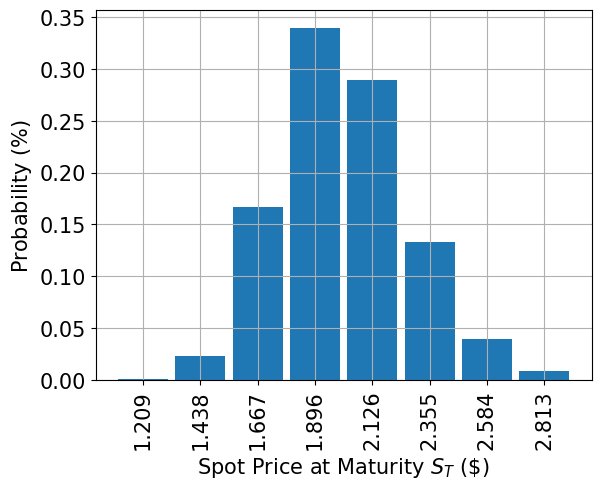

In [250]:
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()

In [251]:
c_approx = 0.25

breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunctionGate(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

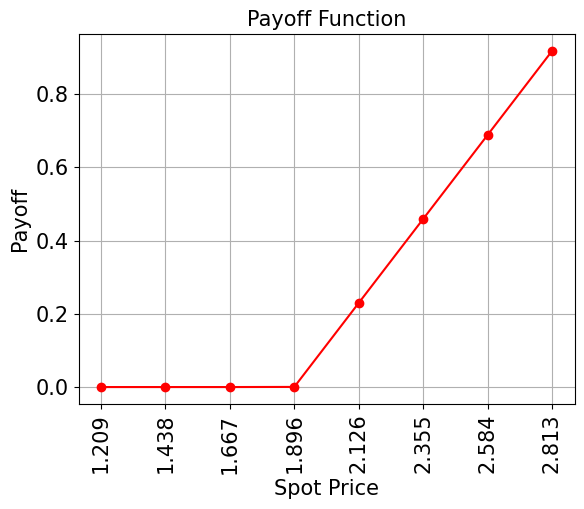

In [252]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [253]:
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[x >= strike_price])
print("exact expected value:\t%.4f" % exact_value)
print("exact delta value:   \t%.4f" % exact_delta)

exact expected value:	0.1623
exact delta value:   	0.8098


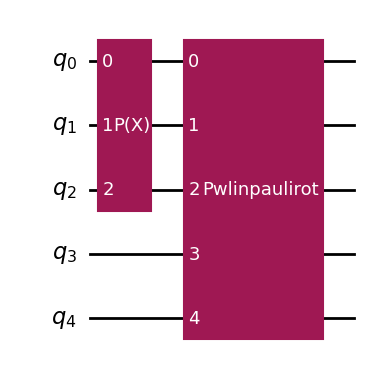

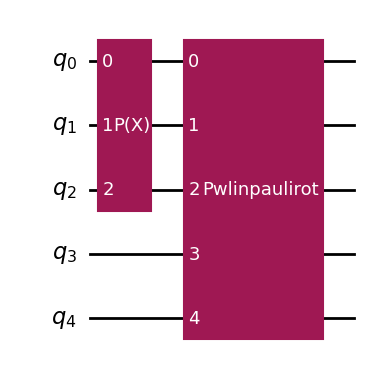

In [254]:
european_call.decompose().draw(output='mpl')

In [255]:
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[3],
    post_processing=european_call_objective.post_processing,
)

ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=StatevectorSampler()
)

In [256]:
result = ae.estimate(problem)

In [257]:
conf_int = np.array(result.confidence_interval_processed)
record_result(
    method="IAE (StatevectorSampler, ideal, manually constructed circuit)",
    estimate=result.estimation_processed,
    ci_low=conf_int[0],
    ci_high=conf_int[1],
    circuit_width=european_call.num_qubits,
)

print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.1623
Estimated value:    	0.1659
Confidence interval:	[0.1572, 0.1746]


# Approach 2: Using Qiskit Finance Application Classes

In [258]:
european_call_pricing = EuropeanCallPricing(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

In [259]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = european_call_pricing.to_estimation_problem()
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=StatevectorSampler()
)
result = ae.estimate(problem)

conf_int = np.array(result.confidence_interval_processed)
record_result("IAE (StatevectorSampler, ideal, library circuit)", european_call_pricing.interpret(result), conf_int[0], conf_int[1], circuit_width=problem.state_preparation.num_qubits)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.1623
Estimated value:    	0.1700
Confidence interval:	[0.1612, 0.1787]


In [260]:
european_call_delta = EuropeanCallDelta(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

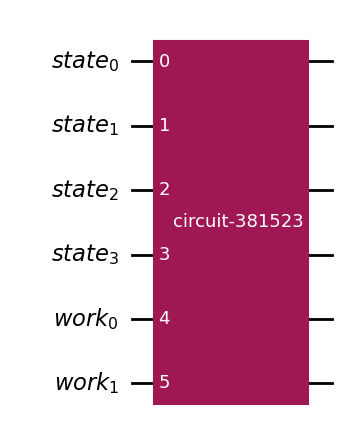

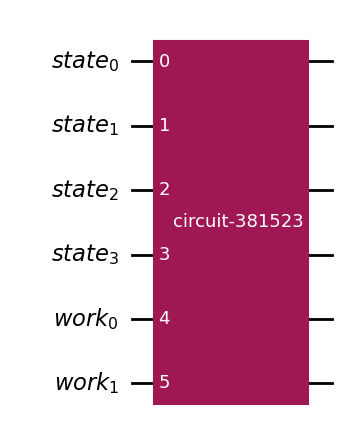

In [261]:
european_call_delta._objective.decompose().draw(output='mpl')

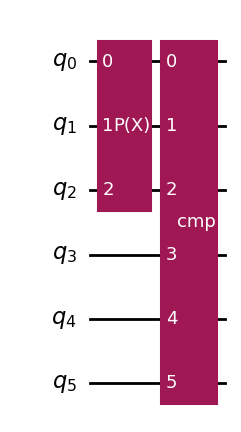

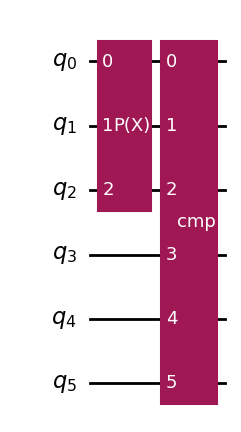

In [262]:
european_call_delta_circ = QuantumCircuit(european_call_delta._objective.num_qubits)
european_call_delta_circ.append(uncertainty_model, range(num_uncertainty_qubits))
european_call_delta_circ.append(
    european_call_delta._objective, range(european_call_delta._objective.num_qubits)
)

european_call_delta_circ.decompose().draw(output='mpl')

In [263]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = european_call_delta.to_estimation_problem()

ae_delta = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=StatevectorSampler()
)

In [264]:
result_delta = ae_delta.estimate(problem)

In [265]:
conf_int = np.array(result_delta.confidence_interval_processed)
print("Exact delta:    \t%.4f" % exact_delta)
print("Estimated value: \t%.4f" % european_call_delta.interpret(result_delta))
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact delta:    	0.8098
Estimated value: 	0.8095
Confidence interval: 	[0.8070, 0.8121]


# Running QAE on quantum hardware and AER Simulator

In [266]:
# ---- helper to avoid IAE crashing on missing pub_result.metadata["shots"] ----
class _JobWrap:
    def __init__(self, job, forced_shots: int):
        self._job = job
        self._shots = int(forced_shots)

    def result(self, *args, **kwargs):
        res = self._job.result(*args, **kwargs)
        try:
            for pubres in res:
                md = getattr(pubres, "metadata", None)
                if isinstance(md, dict) and "shots" not in md:
                    md["shots"] = self._shots
        except Exception:
            pass
        return res

class SamplerWithShots:
    def __init__(self, base_sampler, forced_shots: int):
        self._base = base_sampler
        self._shots = int(forced_shots)

    def run(self, pubs, **kwargs):
        kwargs.pop("shots", None)
        job = self._base.run(pubs, shots=self._shots, **kwargs)
        return _JobWrap(job, self._shots)

In [267]:
api_token = os.getenv("IBM_QUANTUM_TOKEN")
instance = os.getenv("IBM_QUANTUM_INSTANCE")

if not api_token:
    raise RuntimeError("IBM_QUANTUM_TOKEN not found.")

if not QiskitRuntimeService.saved_accounts():
    kwargs = dict(token=api_token, channel="ibm_quantum_platform", set_as_default=True)
    if instance:
        kwargs["instance"] = instance
    QiskitRuntimeService.save_account(**kwargs)

service = QiskitRuntimeService()

# 3-qubit paper-style runs

In [268]:
# ===== Common setup (3q direct sampling) =====

# --- Required globals (should already exist earlier in your notebook) ---
# spot_price, strike_price, volatility, risk_free_rate, time_to_maturity
# mu, sigma, low, high
_missing = [k for k in ["spot_price","strike_price","volatility","risk_free_rate","time_to_maturity","mu","sigma","low","high"] if k not in globals()]
if _missing:
    raise RuntimeError(f"Missing required variables in notebook globals: {_missing}")

# --- IBM account/service (used by both Aer-from-backend and hardware) ---
IBM_TOKEN = os.getenv("IBM_QUANTUM_TOKEN")
IBM_INSTANCE = os.getenv("IBM_QUANTUM_INSTANCE")
if not IBM_TOKEN:
    raise RuntimeError("Set IBM_QUANTUM_TOKEN (or IBM_QUANTUM_KEY) in your environment/.env")

if not QiskitRuntimeService.saved_accounts():
    kwargs = dict(token=IBM_TOKEN, channel="ibm_quantum_platform", set_as_default=True)
    if IBM_INSTANCE:
        kwargs["instance"] = IBM_INSTANCE
    QiskitRuntimeService.save_account(**kwargs)

service = QiskitRuntimeService()

BACKEND_NAME = "ibm_fez"   # change if needed
SHOTS_3Q = 4096           # adjust
C_APPROX = 0.25           # paper uses c = 0.25

def _extract_counts_from_pub(pub):
    """Robustly extract counts dict {bitstring: count} from a Sampler v2 PubResult."""
    try:
        return pub.join_data().get_counts()
    except Exception:
        reg = next(iter(pub.data.values()))
        return reg.get_counts()

def build_3q_direct_sampling():
    """
    Returns:
      A3_meas: 3-qubit circuit with a 1-bit measurement (objective qubit)
      post_process_from_p: function mapping p(obj=1) -> discounted option price
      p1_ideal: ideal p(obj=1) from statevector (sanity check)
    """
    num_state = 2
    objective_qubit = 2
    low_f = float(np.asarray(low))
    high_f = float(np.asarray(high))

    # Discretization grid for scaling payoff in the paper-style mapping
    grid = np.linspace(low_f, high_f, 2**num_state)
    payoffs = np.maximum(0.0, grid - float(strike_price))
    f_min = float(payoffs.min())
    f_max = float(payoffs.max())
    if (f_max - f_min) < 1e-12:
        raise RuntimeError("Degenerate payoff range for 3q. Check bounds/strike/spot.")

    tilde = 2.0 * (payoffs - f_min) / (f_max - f_min) - 1.0          # in [-1, 1]
    angles = 2.0 * (np.pi/4.0 + C_APPROX * tilde)                    # Ry angles

    discount = float(np.exp(-risk_free_rate * time_to_maturity))

    def post_process_from_p(p1: float) -> float:
        # First-order inversion used in the paper-style approximation
        e_tilde = (p1 - 0.5) / C_APPROX
        e_payoff = ((e_tilde + 1.0) / 2.0) * (f_max - f_min) + f_min
        # mild clamp to avoid wild negatives from noise
        e_payoff = float(np.clip(e_payoff, -0.25*f_max, 1.25*f_max))
        return discount * max(0.0, e_payoff)

    def add_piecewise_ctrl_ry(qc: QuantumCircuit, ctrl_qubits, tgt, angles):
        # Apply controlled-Ry(theta_j) triggered on each basis state j of control qubits
        n = len(ctrl_qubits)
        for j, theta in enumerate(angles):
            bits_lsb = format(j, f"0{n}b")[::-1]  # qubit0 is LSB in Qiskit indexing
            for k, b in enumerate(bits_lsb):
                if b == "0":
                    qc.x(ctrl_qubits[k])
            qc.append(RYGate(float(theta)).control(n), ctrl_qubits + [tgt])
            for k, b in enumerate(bits_lsb):
                if b == "0":
                    qc.x(ctrl_qubits[k])

    # Build A3 = distribution prep + payoff encoding
    unc = LogNormalDistribution(num_state, mu=mu, sigma=sigma**2, bounds=(low_f, high_f))

    A3 = QuantumCircuit(3, 1)
    A3.compose(unc, qubits=[0, 1], inplace=True)
    add_piecewise_ctrl_ry(A3, ctrl_qubits=[0, 1], tgt=objective_qubit, angles=angles)
    A3.measure(objective_qubit, 0)

    # Ideal sanity check (noiseless)
    A3_nom = A3.remove_final_measurements(inplace=False)
    sv = Statevector.from_instruction(A3_nom)
    probs = sv.probabilities()  # ordering |q2 q1 q0|
    p1_ideal = float(np.sum(probs[4:8]))  # q2=1 -> indices 4..7

    return A3, post_process_from_p, p1_ideal

A3_3q, post_process_3q, p1_ideal_3q = build_3q_direct_sampling()
print(f"[3q setup] width={A3_3q.num_qubits}, ideal p(obj=1)={p1_ideal_3q:.6f}, shots={SHOTS_3Q}")


[3q setup] width=3, ideal p(obj=1)=0.353875, shots=4096


In [269]:
# ===== 3q direct sampling on Noisy Aer (from IBM backend) =====
backend_for_noise = service.backend(BACKEND_NAME)
print(f"[3q noisy] backend for noise model: {backend_for_noise.name}")

sim_backend = AerSimulator.from_backend(backend_for_noise)
pm = generate_preset_pass_manager(backend=sim_backend, optimization_level=1)
A3_t = pm.run(A3_3q)

sampler = BackendSamplerV2(backend=sim_backend)
job = sampler.run([A3_t], shots=SHOTS_3Q)
pub = job.result()[0]
counts = _extract_counts_from_pub(pub)

p1 = counts.get("1", 0) / SHOTS_3Q
price = post_process_3q(p1)

# Binomial CI on p -> map through post-processing
z = 1.96
se = np.sqrt(max(p1*(1-p1), 1e-12) / SHOTS_3Q)
p_lo = float(np.clip(p1 - z*se, 0.0, 1.0))
p_hi = float(np.clip(p1 + z*se, 0.0, 1.0))
ci_lo = post_process_3q(p_lo)
ci_hi = post_process_3q(p_hi)
ci_lo, ci_hi = sorted([ci_lo, ci_hi])

print("\n" + "="*40)
print(f"3Q DIRECT (NOISY AER, {backend_for_noise.name})")
print("="*40)
print(f"p(objective=1):      {p1:.6f}")
print(f"Estimated Price:     ${price:.6f}")
print(f"Approx CI (95%):     [${ci_lo:.6f}, ${ci_hi:.6f}]")
print("="*40)

# Optional: log using your existing logger
try:
    record_result(f"3Q Direct (Noisy Aer, {backend_for_noise.name})", price, ci_lo, ci_hi,
                  circuit_width=3, shots=SHOTS_3Q)
except NameError:
    pass


[3q noisy] backend for noise model: ibm_fez

3Q DIRECT (NOISY AER, ibm_fez)
p(objective=1):      0.381104
Estimated Price:     $0.239227
Approx CI (95%):     [$0.212087, $0.266366]


In [270]:
# ===== 3q direct sampling on IBM hardware (SamplerV2) =====

backend = service.backend(BACKEND_NAME)
print(f"🚀 Selected Backend: {backend.name}")
print(f"   Status: {backend.status().to_dict()}")

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
A3_t_hw = pm.run(A3_3q)

sampler = SamplerV2(mode=backend)
job = sampler.run([A3_t_hw], shots=SHOTS_3Q)
pub = job.result()[0]
counts = _extract_counts_from_pub(pub)

p1 = counts.get("1", 0) / SHOTS_3Q
price = post_process_3q(p1)

# Binomial CI on p -> map through post-processing
z = 1.96
se = np.sqrt(max(p1*(1-p1), 1e-12) / SHOTS_3Q)
p_lo = float(np.clip(p1 - z*se, 0.0, 1.0))
p_hi = float(np.clip(p1 + z*se, 0.0, 1.0))
ci_lo = post_process_3q(p_lo)
ci_hi = post_process_3q(p_hi)
ci_lo, ci_hi = sorted([ci_lo, ci_hi])

print("\n" + "="*40)
print(f"3Q DIRECT (HARDWARE, {backend.name})")
print("="*40)
print(f"p(objective=1):      {p1:.6f}")
print(f"Estimated Price:     ${price:.6f}")
print(f"Approx CI (95%):     [${ci_lo:.6f}, ${ci_hi:.6f}]")
print("="*40)

# Optional: log using your existing logger
try:
    record_result(f"3Q Direct (IBM Hardware, {backend.name})", price, ci_lo, ci_hi,
                  circuit_width=3, shots=SHOTS_3Q)
except NameError:
    pass


🚀 Selected Backend: ibm_fez
   Status: {'backend_name': 'ibm_fez', 'backend_version': '', 'operational': True, 'pending_jobs': 0, 'status_msg': 'active'}

3Q DIRECT (HARDWARE, ibm_fez)
p(objective=1):      0.387451
Estimated Price:     $0.250809
Approx CI (95%):     [$0.223585, $0.278033]


# 5-qubit runs

In [271]:
# ---- build simplified 2-qubit problem for NISQ ----
hw_qubits = 2
hw_epsilon = 0.1
alpha = 0.05
shots = DEFAULT_SHOTS

low_f = float(np.asarray(low))
high_f = float(np.asarray(high))

hw_model = LogNormalDistribution(hw_qubits, mu=mu, sigma=sigma**2, bounds=(low_f, high_f))
hw_pricing = EuropeanCallPricing(
    num_state_qubits=hw_qubits,
    strike_price=strike_price,
    rescaling_factor=0.25,
    bounds=(low_f, high_f),
    uncertainty_model=hw_model,
)
hw_problem = hw_pricing.to_estimation_problem()

required_qubits = hw_problem.state_preparation.num_qubits
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=required_qubits)


In [272]:
# --- 5-qubit noisy Simulation (Local Aer using IBM backend noise model) ---

print(f"🚀 Selected backend (for noise model): {backend.name}")
print(f"Estimated circuit width (qubits): {required_qubits}")

# ---- noisy simulator derived from backend properties ----
try:
    sim_backend = AerSimulator.from_backend(backend)
    print("Local simulator: AerSimulator.from_backend(backend) (device-derived noise)")
except Exception as e:
    sim_backend = AerSimulator()
    print(f"Local simulator: AerSimulator() fallback (reason: {e})")

pm_sim = generate_preset_pass_manager(backend=sim_backend, optimization_level=1)
sim_sampler = SamplerWithShots(BackendSamplerV2(backend=sim_backend), shots)

ae_sim = IterativeAmplitudeEstimation(
    epsilon_target=hw_epsilon,
    alpha=alpha,
    sampler=sim_sampler,
    transpiler=pm_sim,
)

print("⏳ Running IAE on noisy local simulator...")
result_sim = ae_sim.estimate(hw_problem)

aer_est_price = hw_pricing.interpret(result_sim)
aer_ci_low, aer_ci_high = result_sim.confidence_interval_processed

print("\n" + "=" * 40)
print("LOCAL (AER) RESULT")
print("=" * 40)
print(f"Estimated Price:     ${aer_est_price:.6f}")
print(f"Confidence Interval: [${aer_ci_low:.6f}, ${aer_ci_high:.6f}]")
print("=" * 40)

# ---- Save outputs for downstream analysis/plots ----
record_result(
    method=f"IAE (5q) Noisy Aer ({backend.name})",
    estimate=aer_est_price,
    ci_low=aer_ci_low,
    ci_high=aer_ci_high,
    shots=int(shots),
    circuit_width=int(required_qubits),
)

🚀 Selected backend (for noise model): ibm_fez
Estimated circuit width (qubits): 5
Local simulator: AerSimulator.from_backend(backend) (device-derived noise)
⏳ Running IAE on noisy local simulator...

LOCAL (AER) RESULT
Estimated Price:     $0.215404
Confidence Interval: [$0.172405, $0.258403]


In [273]:
# --- 5-qubit Hardware Execution (IBM Cloud, Runtime V2 / SamplerV2, ISA transpilation) ---

print(f"🚀 Selected Backend: {backend.name}")
print(f"Estimated circuit width (qubits): {required_qubits}")
print(f"   Status: {backend.status().to_dict()}")

# ---- Runtime V2: ISA transpilation is required ----
pm_hw = generate_preset_pass_manager(backend=backend, optimization_level=1)
base_sampler = SamplerV2(mode=backend)
sampler = SamplerWithShots(base_sampler, shots)

ae_hw = IterativeAmplitudeEstimation(
    epsilon_target=hw_epsilon,
    alpha=alpha,
    sampler=sampler,
    transpiler=pm_hw,
)

print("⏳ Submitting IAE job to IBM Quantum... (queues like a standard job)")
result_hw = ae_hw.estimate(hw_problem)

hw_est_price = hw_pricing.interpret(result_hw)
hw_ci_low, hw_ci_high = result_hw.confidence_interval_processed

print("\n" + "=" * 40)
print(f"HARDWARE RESULT ({backend.name})")
print("=" * 40)
print(f"Estimated Price:     ${hw_est_price:.6f}")
print(f"Confidence Interval: [${hw_ci_low:.6f}, ${hw_ci_high:.6f}]")
print("=" * 40)
print("Note: deviation vs ideal is expected due to NISQ noise.")

# ---- Save outputs for downstream analysis/plots ----
record_result(
    method=f"IAE (5q) IBM Hardware ({backend.name})",
    estimate=hw_est_price,
    ci_low=hw_ci_low,
    ci_high=hw_ci_high,
    shots=int(shots),
    circuit_width=int(required_qubits),
)

🚀 Selected Backend: ibm_fez
Estimated circuit width (qubits): 5
   Status: {'backend_name': 'ibm_fez', 'backend_version': '', 'operational': True, 'pending_jobs': 0, 'status_msg': 'active'}
⏳ Submitting IAE job to IBM Quantum... (queues like a standard job)

HARDWARE RESULT (ibm_fez)
Estimated Price:     $0.238194
Confidence Interval: [$0.195022, $0.281366]
Note: deviation vs ideal is expected due to NISQ noise.


# Data plotting and analysis

,Method,Estimate,CI Low,CI High,samples,circuit_width,shots
0,Classical MC (benchmark),0.169746,N/A,N/A,"10,000,000",N/A,N/A
1,"IAE (StatevectorSampler, ideal, manually const...",0.165905,0.157164,0.174645,N/A,5,N/A
2,"IAE (StatevectorSampler, ideal, library circuit)",0.169999,0.161249,0.178750,N/A,7,N/A
3,"3Q Direct (Noisy Aer, ibm_fez)",0.239227,0.212087,0.266366,N/A,3,"4,096"
4,"3Q Direct (IBM Hardware, ibm_fez)",0.250809,0.223585,0.278033,N/A,3,"4,096"
5,IAE (5q) Noisy Aer (ibm_fez),0.215404,0.172405,0.258403,N/A,5,"4,096"
6,IAE (5q) IBM Hardware (ibm_fez),0.238194,0.195022,0.281366,N/A,5,"4,096"


Loaded results from: memory
Saved plot to: results/price_forest.png


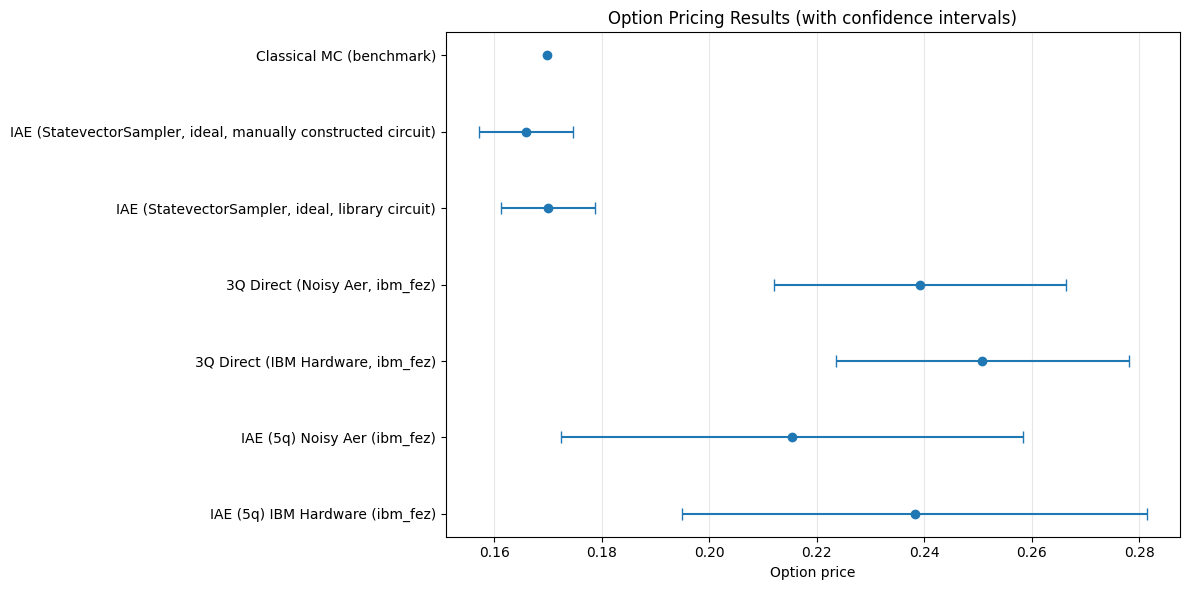

In [274]:
df = get_results_df()
if df.empty:
    raise RuntimeError("No results found in memory or results/summary_prices.csv|.jsonl")

# Ensure required columns exist
for col in ["Method", "Estimate", "CI Low", "CI High"]:
    if col not in df.columns:
        df[col] = np.nan
        
# 1) Work on a numeric copy for computations
df_num = df.copy()

for col in ["Estimate", "CI Low", "CI High", "shots", "samples", "circuit_width", "circuit_depth"]:
    if col in df_num.columns:
        df_num[col] = pd.to_numeric(df_num[col], errors="coerce")

# swap bounds if reversed (NUMERIC ONLY)
if {"CI Low","CI High"}.issubset(df_num.columns):
    swap = np.isfinite(df_num["CI Low"]) & np.isfinite(df_num["CI High"]) & (df_num["CI Low"] > df_num["CI High"])
    df_num.loc[swap, ["CI Low", "CI High"]] = df_num.loc[swap, ["CI High", "CI Low"]].to_numpy()

# 2) Create a display copy with formatting
df_display = df_num.copy()

# integer-like columns (commas)
for col in ["shots", "samples", "circuit_width", "circuit_depth"]:
    if col in df_display.columns:
        df_display[col] = df_display[col].astype("Int64")
        df_display[col] = df_display[col].map(lambda x: f"{int(x):,}" if pd.notna(x) else "N/A")

# float columns (keep decimals, but N/A for missing)
for col in ["Estimate", "CI Low", "CI High", "epsilon"]:
    if col in df_display.columns:
        df_display[col] = df_display[col].map(lambda x: f"{x:.6f}" if pd.notna(x) else "N/A")

# any remaining missing -> N/A
df_display = df_display.replace({pd.NA: "N/A", np.nan: "N/A"})

display(df_display)
# Forest plot (robust to invalid CI rows)
fig, ax = plt.subplots(figsize=(12, 6))
y = np.arange(len(df))[::-1]
x = df["Estimate"].to_numpy()
lo = df["CI Low"].to_numpy()
hi = df["CI High"].to_numpy()

mask = np.isfinite(lo) & np.isfinite(hi)
err_left = x - lo
err_right = hi - x
mask2 = mask & (err_left >= 0) & (err_right >= 0)

ax.scatter(x, y)
if mask2.any():
    xerr2 = np.vstack([err_left[mask2], err_right[mask2]])
    ax.errorbar(x[mask2], y[mask2], xerr=xerr2, fmt="none", capsize=4)

bad = np.where(mask & ~mask2)[0]
if len(bad):
    print("Skipped invalid CI rows (CI does not contain estimate):")
    for i in bad:
        print(f"  {df.iloc[i]['Method']}: est={x[i]:.6f}, CI=[{lo[i]:.6f}, {hi[i]:.6f}]")

ax.set_yticks(y)
ax.set_yticklabels(df["Method"].tolist())
ax.set_xlabel("Option price")
ax.set_title("Option Pricing Results (with confidence intervals)")
ax.grid(True, axis="x", alpha=0.3)
fig.tight_layout()
fig.savefig(RESULTS_DIR / "price_forest.png", dpi=220, bbox_inches="tight")

print("Loaded results from:", "memory" if len(PRICE_LOG) else "results/summary_prices.csv|.jsonl")
print("Saved plot to: results/price_forest.png")
